# CYPLAN 255 Project

## Using Open-Source Bike Share Trip Data to Inform Social Distancing Street Closures

### `1_Explore_BayWheels_Trips`

This data does less processing and more exploratory analysis to visualize the Bay Wheels origin-destination trips. The charts and figures created in this notebook can be used to set the stage for further analysis and provide background information on the data.

**Datasets used:**
* [System data](https://www.lyft.com/bikes/bay-wheels/system-data) from Bay Wheels.
* [Regional bicycle facilities](http://opendata.mtc.ca.gov/datasets/regional-bike-facilities?geometry=-122.400%2C37.800%2C-122.144%2C37.847) in the Bay Area. From the Metropolitan Transportation Commission.

**Notebook summary:**
* 1.0 - Import packages
* 1.1 - Import data
* 1.2 - Create a heatmap of trips by time of day and day of the week using Seaborn
* 1.3 - Explore the breakdown of type of bike facility in the Bay Area
* 1.4 - Map the change in station usage as a result of COVID-19
* 1.5 - Extra visualizations for in-class presentation

## 1.0 Initialize notebook

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set()

## 1.1 Load (and clean) data

In [3]:
# load station location data
stations = gpd.read_file("../data/baywheels_stations.geojson")

In [4]:
# load bicycle facilities in Bay Area
facilities = gpd.read_file("../data/regional_bike_facilities.geojson")

# class / class_type :
# 1 = 'Off-Street Shared-Use Path'
# 2 = 'Bike Lane'
# 3 = 'On-Street Bike Route'

In [5]:
# load bounding boxes for station regions
bbox_gdf = gpd.read_file("../data/baywheels_regions_bbox.geojson")

In [6]:
# load raw trip data
trips_Feb20 = pd.read_csv("../data/202002-baywheels-tripdata.csv", low_memory=False)
trips_Mar20 = pd.read_csv("../data/202003-baywheels-tripdata.csv", low_memory=False)

In [7]:
# Create function to clean trip data
def clean_tripdata(trips):
    # Drop outlier tips that are too long from the dataset because they are likely circuitious or erroneous.
    trips = trips.loc[trips.duration_sec <= trips.duration_sec.quantile(0.99)]

    # Drop all trips that start and end in the same location.
    trips = trips.loc[trips.start_station_id != trips.end_station_id]
    
    # Drop all trips to station 449 (located at equator, not a real station)
    trips = trips.loc[(trips.start_station_id!=449.0) | (trips.end_station_id!=449.0)]
    
    # Return cleaned dataframe
    return trips

# Clean trip data
trips_Feb20 = clean_tripdata(trips_Feb20)
trips_Mar20 = clean_tripdata(trips_Mar20)

## 1.2 Heatmap

When do people use Bay Wheels? Are trips taken for leisure or for a purpose? Seaborn has a heatmap visualization that can plot a month of Bay Wheel trips by day of the week and time of day.

Sources referenced for this section:
* http://seaborn.pydata.org/examples/heatmap_annotation.html
* https://seaborn.pydata.org/generated/seaborn.heatmap.html

Additional sources that could be used to create time series animations of these heatmaps:
* Code for [creating animations](https://stackoverflow.com/questions/46236902/redrawing-seaborn-figures-for-animations) in matplotlib
* Simpler [animation](https://python-graph-gallery.com/340-scatterplot-animation/) in seaborn using gifs

Let's start by visualizing trips in **February 2020**, the month before shelter-in-place orders were declared in the Bay Area due to the spread of COVID-19. This will be more similar to a typical month of Bay Wheels travel than more recent data.

In [8]:
# set our trips df
trips = trips_Feb20.copy()

# truncate data to be list of trip counts by day of week (0-6) and hour of day (0-23)
trips['start_time'] = pd.to_datetime(trips.start_time, format='%Y-%m-%d %H:%M:%S.%f')
trips['day'] = trips['start_time'].dt.weekday
trips['hour'] = trips['start_time'].dt.hour
heatmap_df = trips.groupby(['day', 'hour']).start_time.count().reset_index()
heatmap_df.rename(columns={"start_time": "count"}, inplace=True)

In [9]:
# convert to long-form and rename index
heatmap_df = heatmap_df.pivot("day", "hour", "count")
heatmap_df.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
heatmap_df.index.name = 'day'

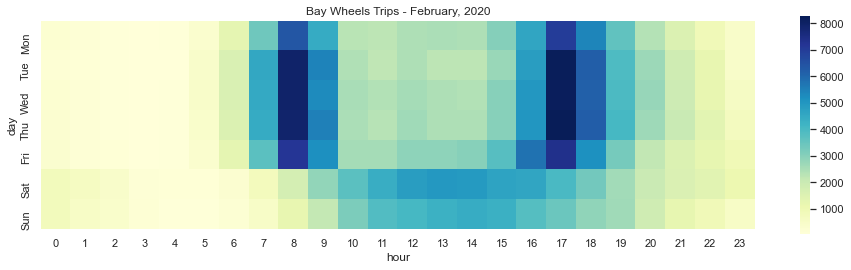

In [10]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(16, 4))
ax.set_title("Bay Wheels Trips - February, 2020")
sns.heatmap(heatmap_df, 
            cmap="YlGnBu", 
            square=True, 
            vmax=heatmap_df.max().max(), # set to the maximum value in our dataset
            ax=ax)

There are distinct trip patterns. During weekdays people are most frequently using Bay Wheels for travel between 8am-9am and 5pm-6pm, which lines up with peak period travel for work. There are trips made during weekdays outside of these times but not to the same magnitude.

On the weekend the morning/evening work trip peaks disappear. Instead people are using Bay Wheels bikes for trips during the middle of the day. These are likely leisure or errand trips for people moving around on the weekend. They do not occur with the same magnitude as weekday peak period trips. When exploring trip routes it may make sense to split up weekday and weekend travel because trip patterns may differ with trip purpose.

Bay Wheels is not often used in the evening, possibly because people do not feel safe biking at night.

That heatmap was for trips taken in **February 2020**...what about trips during **March 2020**? At this point the COVID-19 pandemic has spread through the Bay Area and residents were ordered to shelter-in-place for most of the month.

In [11]:
# Create a function out of the heatmap code so we can replicate it with data from different months
def sns_heatmap(trips, title):
    # truncate data to be list of trip counts by day of week (0-6) and hour of day (0-23)
    trips['start_time'] = pd.to_datetime(trips.start_time, format='%Y-%m-%d %H:%M:%S.%f')
    trips['day'] = trips['start_time'].dt.weekday
    trips['hour'] = trips['start_time'].dt.hour
    heatmap_df = trips.groupby(['day', 'hour']).start_time.count().reset_index()
    heatmap_df.rename(columns={"start_time": "count"}, inplace=True)

    # convert to long-form and rename index
    heatmap_df = heatmap_df.pivot("day", "hour", "count")
    heatmap_df.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    heatmap_df.index.name = 'day'

    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(16, 4))
    ax.set_title(title)
    sns.heatmap(heatmap_df, 
                cmap="YlGnBu", 
                square=True, 
                vmax=heatmap_df.max().max(),
                ax=ax)

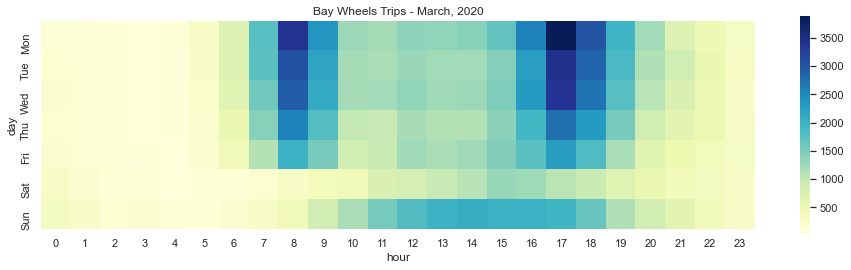

In [12]:
# plot heatmap of Bay Wheels trips from March 2020
sns_heatmap(trips_Mar20.copy(), "Bay Wheels Trips - March, 2020")

Woah that is a sharp decrease in travel! It appears that there are still dominant travel peaks in the morning and evening during weekdays, but their maximum (3881) is about less than half of that in February (8261). The shelter-in-place order was declared on March 16th (and started the next day), so maybe this pattern is a remnant from the trips before?

In [13]:
# turn trip start_time into a datetime
trips_Mar20['start_time'] = pd.to_datetime(trips_Mar20.start_time, format='%Y-%m-%d %H:%M:%S.%f')

# print the number of trips taken before/after March 16th
print(f"Trips taken before shelter-in-place: {len(trips_Mar20[trips_Mar20.start_time.dt.day <= 16])}")
print(f"Trips taken after shelter-in-place: {len(trips_Mar20[trips_Mar20.start_time.dt.day > 16])}")

Trips taken before shelter-in-place: 139317
Trips taken after shelter-in-place: 31170


So there are over 4x less trips taken after the shelter-in-place order was declared. Let's make these heatmaps one more time, but separated by date.

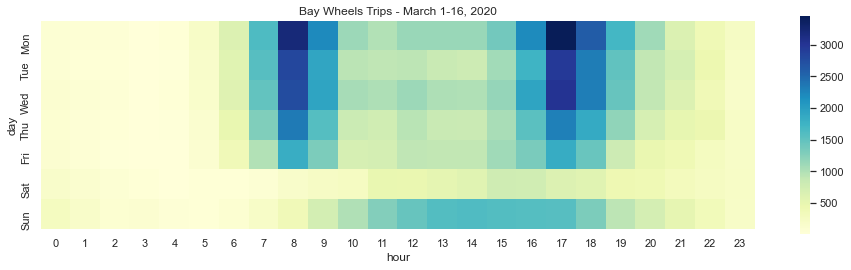

In [14]:
# plot heatmap of Bay Wheels trips March 1-16, 2020
sns_heatmap(trips_Mar20[trips_Mar20.start_time.dt.day <= 16].copy(), "Bay Wheels Trips - March 1-16, 2020")

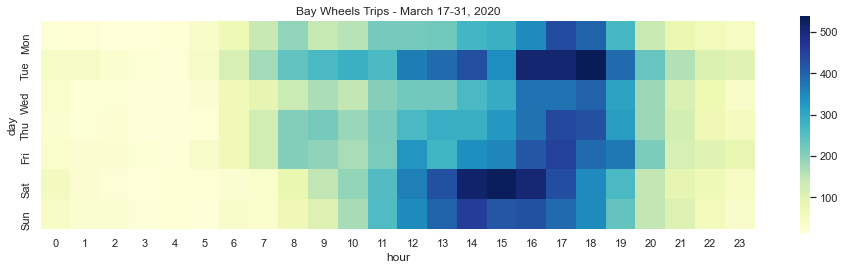

In [15]:
# plot heatmap of Bay Wheels trips March 17-31, 2020
sns_heatmap(trips_Mar20[trips_Mar20.start_time.dt.day > 16].copy(), "Bay Wheels Trips - March 17-31, 2020")

This is such a noticable difference! 

The AM and PM peak commutes have disappeared from weekday trips. It even appears that people may be waking up later because trips don't start occuring in mass until noon most days. Now the majority of trips appear to be on the weekends, likely when people working from home during the week are off and can get outside for some (socially-distanced) exercise. However, the quantity of trips taken is much lower than the first half of the month.

Is the decreased usage related to fears of transmission of COVID-19 through the bike share system? What is Bay Wheels doing to keep bike sanitized? Have stations been closed to restrict movement or are all the bicycles still available. These questions are important but are not answered through this heatmap.

## 1.3 Bike facility breakdown by type

What kind of bike facilities are there in the Bay? How many lane-miles are there of each type? How many lane-miles are in each Bay Wheels region?

In [16]:
# Convert the gdf to NAD83 (a projected coordinate system) so we can get length
# measurements in meters.
facilities = facilities.to_crs('epsg:3310')

# Create a new column with the length of each facility (meters and miles)
facilities['length'] = facilities.geometry.length
facilities['length_mi'] = facilities.geometry.length * 0.000621371

In [17]:
# Group bike facilities by type to see the average length and total length of bike facilities
# in the system.
facilities.groupby('class_type').agg({'length_mi': ['mean','sum']})

length_mi             
                                mean          sum
class_type                                       
Bike Lane                   0.440772  1578.843742
Off-Street Shared-Use Path  0.578930   638.559838
On-Street Bike Route        0.420092  1066.192423

On average the length of off-street shared-use paths are the greatest. This makes sense because these routes may often be through parks or other areas that do not have to be broken up by street intersections. However, there are the fewest total lane-miles of that type of bicycle facility. The majority of bike facilities in the Bay Area are bike lanes. Unfortunately, these are the most dangerous of the three because they do not offer the same level of protection that the other two classes do (because they provide separation from faster traffic and heavy vehicles). 

When looking at what streets to recommend for closure to vehicles to promote social distancing it may not be necessary to prioritize protected bike lanes because there will be no traffic. However, separation of modes by speed can minimize accidents between bicycles and pedestrians and should be considered.

In [18]:
# Reproject bounding box gdf to NAD83 so we can use overlay the dataset with the 
# bike share region bounding boxes
bbox_gdf = bbox_gdf.to_crs('epsg:3310')

# Calculate attributes of the bike facilities in each region
print("region / sum of length / mean length")
for index, row in bbox_gdf.iterrows():
    x = facilities.loc[facilities.within(row['geometry'])]
    s = sum(x.length_mi)
    a = s/len(x)
    print(row['region'], "/", s, "/", a)

region / sum of length / mean length
East Bay / 110.6196128053339 / 0.27313484643292324
San Francisco / 166.53533284431538 / 0.2794216994032137
San Jose / 21.01767252671965 / 0.44718452184509894


The most lane-miles of bike facilities are in San Francisco (166.5 total miles) but the length of each facility is longest in San Jose. The facility lengths in the East Bay and San Francisco are comprable. Whether this is by design of the jurisdictions or a result of street design (similar street grids?) is unclear.

## 1.4 Change in Station Usage

Above we saw a sharp dropoff in Bay Wheels trips on March 16th, when the Bay Area ordered all residents to shelter-in-place. What stations saw the greatest decrease in trips? What locations may have maintained usage during the pandemic?

I am interested in mapping the stations by the number of origins/destinations there in early and late March (pre- and post-COVID). Below the trips are grouped by their origin-destination pair (to simplify the dataset) and then merged together to create one dataframe with counts of all the unique trips for the sampled months.

In [19]:
# Function to group trips by Origin-Destination pair
def group_trip_pairs(trips):
    # Group trips, only keeping relevant columns
    trips = trips.groupby(["start_station_id", "end_station_id"]).agg({'start_time':'count'})
    
    # Reset index and rename column with count data
    trips.reset_index(inplace=True)
    trips.rename(columns={"start_time": "count"}, inplace=True)
    
    # Return grouped dataframe
    return trips

In [20]:
# Aggregate dataframes using the function created above. We are creating three different tables
# based on our data: February, early March (pre-COVID), and late March (post-COVID).
trips_Feb20_agg = group_trip_pairs(trips_Feb20.copy())
trips_Mar20_pre_agg = group_trip_pairs(trips_Mar20[trips_Mar20.start_time.dt.day <= 16].copy())
trips_Mar20_post_agg = group_trip_pairs(trips_Mar20[trips_Mar20.start_time.dt.day > 16].copy())

In [21]:
# Merge together the counts from February and early March
trips_agg = pd.merge(trips_Feb20_agg, trips_Mar20_pre_agg, how="outer", on=["start_station_id", "end_station_id"])

# Rename columns to more readable labels
trips_agg.rename(columns={"count_x": "count_Feb20", "count_y": "count_Mar20_pre"}, inplace=True)

# Merge together the counts from February and early March with those from late March
trips_agg = pd.merge(trips_agg, trips_Mar20_post_agg, how="outer", on=["start_station_id", "end_station_id"])

# Rename columns to more readable labels
trips_agg.rename(columns={"count": "count_Mar20_post"}, inplace=True)

# Display merged dataframe
trips_agg.head()

,start_station_id,end_station_id,count_Feb20,count_Mar20_pre,count_Mar20_post
0,3.0,4.0,5.0,2.0,1.0
1,3.0,5.0,25.0,10.0,3.0
2,3.0,6.0,9.0,15.0,NaN
3,3.0,8.0,4.0,1.0,NaN
4,3.0,9.0,3.0,NaN,NaN


Looks like there are some null values in our dataset. We merged using an `outer` join to preserve all trips (d-->e may have occured in February but not late March and we don't want to drop that from our dataframe) so places that are missing trips came in as null. Let's force those to be 0 instead.

In [22]:
# fill null values
trips_agg.fillna(0, inplace=True)

# Display dataframe
trips_agg.head()

,start_station_id,end_station_id,count_Feb20,count_Mar20_pre,count_Mar20_post
0,3.0,4.0,5.0,2.0,1.0
1,3.0,5.0,25.0,10.0,3.0
2,3.0,6.0,9.0,15.0,0.0
3,3.0,8.0,4.0,1.0,0.0
4,3.0,9.0,3.0,0.0,0.0


I am interested in the change in trips between early and late March, so let's create a new column with that value.

In [23]:
# Calculate the change in trips between early and late March
trips_agg['count_delta'] = trips_agg['count_Mar20_post'] - trips_agg['count_Mar20_pre']

We already know that there are less trips in late March, but what stations say the largest decrease in usage? Let's start by mapping these trips by their station of origin. To do this we need to further group our dataframe by only the origin station, and then join it with the stations geodataframe to get location information.

In [24]:
# Create a dataframe of origin trips
trips_orig = trips_agg.groupby('start_station_id').sum().reset_index()
trips_orig.drop(columns="end_station_id", inplace=True)

In [25]:
# create geodataframe with trip counts per origin station
orig_gdf = pd.merge(stations, trips_orig, how="left", left_on="station_id", right_on="start_station_id")

# display new geodataframe
orig_gdf.head()

,station_id,name,lat,lon,ox_node,region,geometry,start_station_id,count_Feb20,count_Mar20_pre,count_Mar20_post,count_delta
0,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,6489941287,San Francisco,POINT (-122.40490 37.78638),3.0,1353.0,824.0,172.0,-652.0
1,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,65313138,San Francisco,POINT (-122.40892 37.78588),4.0,201.0,189.0,43.0,-146.0
2,5.0,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,1723739163,San Francisco,POINT (-122.40844 37.78390),5.0,1415.0,758.0,78.0,-680.0
3,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,33241803,San Francisco,POINT (-122.40323 37.80477),6.0,672.0,459.0,74.0,-385.0
4,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,3244767454,East Bay,POINT (-122.27174 37.80456),7.0,618.0,269.0,16.0,-253.0


Now the fun part, let's map it!

In [26]:
# Import the Folium package so we can visualize the data over a Leaflet basemap
import folium

In [41]:
# Reproject the data to WGS84 so it has the same geographic coordinate system as our basemap
bbox_gdf.to_crs('epsg:4326', inplace=True)

In [42]:
# Initialize folium map, with center location pulled from the San Francisco bounding box gdf
m_centroid = bbox_gdf.loc[bbox_gdf.region=='San Francisco'].centroid[1]
m = folium.Map(location=[m_centroid.y, m_centroid.x], 
               tiles="CartoDB Positron",
               zoom_start=13)

# Function to color folium circle markers on whether or not the change in trips is
# positive (blue) or negative (red). The color scheme was taken from https://colorbrewer2.org/
def get_line_color(val):
    if val < 0:
        return "#ef8a62"
    elif val == 0:
        return "#000"
    else:
        return "#67a9cf"

# Loop through Bay Wheels stations with trips counted by origin, add to map
for index, row in orig_gdf.iterrows():
    
    # Get list of tuples containing (lon, lat) coordinates
    coords = list(row.geometry.coords)
    
    # Create html popup for each station
    # From: https://gis.stackexchange.com/questions/185897/how-can-i-include-html-in-a-folium-marker-popup
    html = "<b>Station:</b> "+row['name']+"<br>"+"<b>Trips March 1-16:</b> "+str(row['count_Mar20_pre'])+"<br>"+"<b>Trips March 17-31:</b> "+str(row['count_Mar20_post'])
    iframe = folium.IFrame(html=html, width=200, height=100)
    popup = folium.Popup(iframe, max_width=500)
    
    # Add coordinates to map as a circle marker
    folium.CircleMarker(
        location=[coords[0][1], coords[0][0]],
        # The radius is a function of the count (absolute values because you
        # cannot have a negatively sized circle) normalized by the median value.
        radius=np.abs(row.count_delta)/np.abs(orig_gdf.count_delta).median(),
        popup=popup,
        color=get_line_color(row.count_delta),
        fill=True,
        fill_color=get_line_color(row.count_delta)
    ).add_to(m)

# Display map
m

This isn't as informative as I hoped because nearly all stations see a decrease in trips. However, from scrolling around we can note that certain regions had larger decreases. These are likely locations that are frequented by commuters who are sheltering in place at the end of March.

One of these places is the South side of Berkeley. The University moved classes online in early March and without students getting around the bicycles remained in their docks.

Downtown San Francisco also experienced a large drop in ridership. Stations that are frequented by weekday commuters (San Francisco Caltrain at Townsend and 4th, Montgomery St BART Station, Powell St BART Station) are no longer being used.

Something to also read from this map is that there are many stations that aren't used often. A ton of stations in the East Bay and nearly every station in San Jose was used less than 10 times in early March. So the impact on ridership at these stations after the shelter-in-place order was minimal. Should these stations be removed entirely? How could we encourage more people to use bike share at those locations?

Let's recreate that map with stations group by destinations to see if we can find any other insights. 

In [43]:
# Create a dataframe of destination trips
trips_dest = trips_agg.groupby('end_station_id').sum().reset_index()
trips_dest.drop(columns="start_station_id", inplace=True)

# create geodataframe with trip counts per destination station
dest_gdf = pd.merge(stations, trips_dest, how="left", left_on="station_id", right_on="end_station_id")

In [44]:
# Initialize folium map, with center location pulled from the San Francisco bounding box gdf
m_centroid = bbox_gdf.loc[bbox_gdf.region=='San Francisco'].centroid[1]
m = folium.Map(location=[m_centroid.y, m_centroid.x], 
               tiles="CartoDB Positron",
               zoom_start=13)

# Loop through Bay Wheels stations with trips counted by origin, add to map
for index, row in dest_gdf.iterrows():
    
    # Get list of tuples containing (lon, lat) coordinates
    coords = list(row.geometry.coords)
    
    # Create html popup for each station
    # From: https://gis.stackexchange.com/questions/185897/how-can-i-include-html-in-a-folium-marker-popup
    html = "<b>Station:</b> "+row['name']+"<br>"+"<b>Trips March 1-16:</b> "+str(row['count_Mar20_pre'])+"<br>"+"<b>Trips March 17-31:</b> "+str(row['count_Mar20_post'])
    iframe = folium.IFrame(html=html, width=200, height=100)
    popup = folium.Popup(iframe, max_width=500)
    
    # Add coordinates to map as a circle marker
    folium.CircleMarker(
        location=[coords[0][1], coords[0][0]],
        # The radius is a function of the count (absolute values because you
        # cannot have a negatively sized circle) normalized by the median value.
        radius=np.abs(row.count_delta)/np.abs(orig_gdf.count_delta).median(),
        popup=popup,
        color=get_line_color(row.count_delta),
        fill=True,
        fill_color=get_line_color(row.count_delta)
    ).add_to(m)

# Display map
display(m)

I am not sure if this map shows anything new, but it does drive home the point that commute trips have been hit hard by COVID-19. The largest bubbles (where the greatest decreases in trips between early and late March are) are by BART, Caltrain, and Muni stations. Bay Wheel riders are using the system as a first-mile/last-mile solution!

## 1.5 EXTRAS

Additional code and visualizations for in-class presentation.

In [48]:
# Coordinates representing the streets closed to thru-traffic for social
# distancing in San Francisco. Coordinates manually identified from image
# found here: https://www.sfchronicle.com/bayarea/article/SF-to-begin-closing-city-street-to-cars-to-15215666.php
sf_slowstreets = [
    [(37.784033, -122.419385), (37.784666, -122.414456)],
    [(37.770082, -122.453738), (37.773900, -122.423910)],
    [(37.780800, -122.437270), (37.772413, -122.435579)],
    [(37.763289, -122.421730), (37.762627, -122.432971)],
    [(37.755301, -122.420959), (37.754953, -122.426642)],
    [(37.742983, -122.388430), (37.736726, -122.394080)],
    [(37.725909, -122.378402), (37.732293, -122.389616)],
    [(37.721649, -122.471983), (37.721851, -122.453124)],
    [(37.738283, -122.499013), (37.764360, -122.500842)],
    [(37.758406, -122.509163), (37.760388, -122.463928)],
    [(37.750966, -122.508208), (37.752557, -122.472032)],
    [(37.752322, -122.477434), (37.765400, -122.478333)]
]

In [50]:
# Initialize folium map, with center location pulled from the San Francisco bounding box gdf
m_centroid = bbox_gdf.loc[bbox_gdf.region=='San Francisco'].centroid[1]
m = folium.Map(location=[m_centroid.y, m_centroid.x], 
               tiles="CartoDB Positron",
               zoom_start=12.5)

# Loop through list of SF street closures
for street in sf_slowstreets:
    # add coordinates to map as a polyline
    folium.PolyLine(street, 
                    color='orange', 
                    weight=5, 
                    opacity=0.5,
                    line_cap="butt").add_to(m)


# Loop through Bay Wheels stations with trips counted by origin, add to map
for index, row in dest_gdf.iterrows():
    
    # Get list of tuples containing (lon, lat) coordinates
    coords = list(row.geometry.coords)
    
    # Create html popup for each station
    # From: https://gis.stackexchange.com/questions/185897/how-can-i-include-html-in-a-folium-marker-popup
    html = "<b>Station:</b> "+row['name']+"<br>"+"<b>Trips March 1-16:</b> "+str(row['count_Mar20_pre'])+"<br>"+"<b>Trips March 17-31:</b> "+str(row['count_Mar20_post'])
    iframe = folium.IFrame(html=html, width=200, height=100)
    popup = folium.Popup(iframe, max_width=500)
    
    # Add coordinates to map as a circle marker
    folium.CircleMarker(
        location=[coords[0][1], coords[0][0]],
        # The radius is a function of the count (absolute values because you
        # cannot have a negatively sized circle) normalized by the median value.
        radius=np.abs(row.count_Feb20)/np.abs(dest_gdf.count_Feb20).median(),
        popup=popup,
        #color=get_line_color(row.count_delta),
        fill=True#,
        #fill_color=get_line_color(row.count_delta)
    ).add_to(m)

# Display map
display(m)

Code example for converting bike station trips to routes using OSMnx

In [ ]:
# Get OSM network using OSMnx
G = ox.graph_from_bbox(north, south, east, west, 
                       network_type='bike')

# Convert origin and destination coordinates to OSMnx nodes
origin_node = ox.get_nearest_node(G, origin_lat,
                                     origin_lon)
destination_node = ox.get_nearest_node(G, destination_lat, 
                                          destination_lon)

# Get shortest route between origin and destination
route = nx.shortest_path(G, origin_node, destination_node)

# Convert network nodes and edges to geodataframes
# Then convert route to a Shapely LineString
g_nodes, g_edges = ox.graph_to_gdfs(G)
route_nodes = g_nodes.loc[route]
route_line = LineString(list(route_nodes.geometry.values))